# Project 5: Vehicle Detection

### Detecting vehicles using SVM and OpenCV

### Outline:
    0. Imports
    1. Training SVM
    2. Vehicle Detection
    3. Lane Detection (for completion)
    4. Process Video
    
## 0. Imports

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from collections import deque
import pickle

%matplotlib inline

## 1. Training SVM
#### The methods below are used to extract features and train the linear SVM.

In [2]:
# Converts image color formatting
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2Lab':
        return cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

# HOG features of image
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Spatial features of image
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

# Hist features of image
def color_hist(img, nbins=32, hist_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=hist_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=hist_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=hist_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        #image *= 255.0
        #image = image.astype(np.uint8)

        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'RGB2HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'RGB2LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'RGB2HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'RGB2YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'RGB2YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
            elif color_space == 'RGB2Lab':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2Lab)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins, hist_range=hist_range)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [3]:
# Read in vehicles and non-vehicles
#vehicles = glob.glob('vehicles/GTI_Far/*.png')
#vehicles += glob.glob('vehicles/GTI_Left/*.png')
#vehicles += glob.glob('vehicles/GTI_MiddleClose/*.png')
#vehicles += glob.glob('vehicles/GTI_Right/*.png')
vehicles = glob.glob('vehicles/KITTI_extracted/*.png')[0:2500]
vehicles += glob.glob('vehicles/GTI_extra/*.png')
vehicles += glob.glob('vehicles/Video_extra/*.png')
nonvehicles = glob.glob('non-vehicles/Extras/*.png')[0:2700]
#nonvehicles += glob.glob('non-vehicles/GTI/*.png')

# Reduce the sample size during testing
#sample_size = 5000
#vehicles = vehicles[0:sample_size]
#nonvehicles = nonvehicles[0:sample_size]

print("Number of vehicle images:", len(vehicles))
print("Number of non-vehicles images:", len(nonvehicles))

### TODO: Tweak these parameters and see how the results change.
color_space = 'RGB2YCrCb' # Can be RGB, RGB2HSV, RGB2LUV, RGB2HLS, RGB2YUV, RGB2YCrCb, RGB2Lab
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions, rank: 32 >= 16 
hist_bins = 64    # Number of histogram bins
hist_range=(0, 256)
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

features_v = extract_features(vehicles, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
features_nv = extract_features(nonvehicles, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((features_v, features_nv)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(features_v)), np.zeros(len(features_nv))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
t=time.time()

Number of vehicle images: 2680
Number of non-vehicles images: 2700
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8556
1.57 Seconds to train SVC...
Test Accuracy of SVC =  1.0


## 2. Vehicle Detection
The methods below are used to detect cars in images, create heat maps and draw bounding boxes. HOG subsampling is used to search for vehicles in the image.

In [4]:
# Extracts features and detects vehicles in a given image.
# Retruns windows containing possible detections.
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space='RGB2YCrCb'):

    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv=color_space)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = ((nxblocks - nblocks_per_window) // cells_per_step) + 1
    nysteps = ((nyblocks - nblocks_per_window) // cells_per_step) + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    hot_windows = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                hot_windows.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return hot_windows

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=2):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def add_heat(heatmap, bbox_list, value=1):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += value

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

### Testing detections on sample images

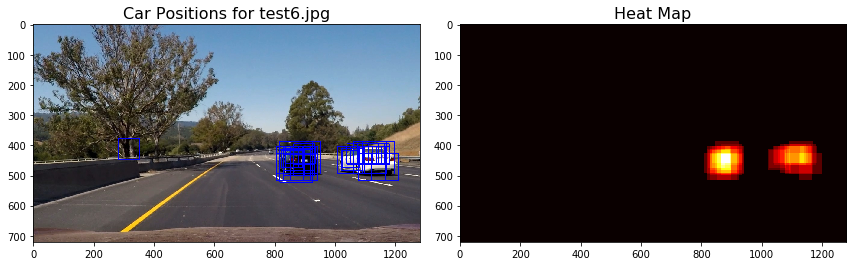

In [44]:
#ystart = 380
#ystop = 480
#scale = 1.6 #0.8, 1.1, 1.4, 1.8, 2.1
all_ystart = (360, 360, 360, 360)
all_ystop = (660, 660, 660, 660)
all_scales = (0.9, 1.1, 1.4, 1.7)

original_image = mpimg.imread('test_images/test6.jpg')
image = original_image.astype(np.float32)/255.0



all_hot_windows = []
for ystart, ystop, scale in zip(all_ystart, all_ystop, all_scales):
    all_hot_windows += find_cars(image, ystart, ystop, scale, svc, 
                                 X_scaler, orient, pix_per_cell, 
                                 cell_per_block, spatial_size, 
                                 hist_bins, color_space)

'''

all_ystart = 360
all_ystop = 660
all_scales = 1.2

all_hot_windows = find_cars(image, all_ystart, all_ystop, all_scales, svc, 
                                 X_scaler, orient, pix_per_cell, 
                                 cell_per_block, spatial_size, 
                                 hist_bins, color_space)

'''

out_image = draw_boxes(original_image, all_hot_windows)

heat = np.zeros_like(original_image[:,:,0]).astype(np.float)
# Add heat to each box in box list
heat = add_heat(heat, all_hot_windows)
# Apply threshold to help remove false positives
heat = apply_threshold(heat, 1)
# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)
# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(original_image), labels)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
ax1.imshow(out_image)
ax1.set_title('Car Positions for test6.jpg', fontsize=16)
ax2.imshow(heatmap, cmap='hot')
ax2.set_title('Heat Map', fontsize=16)
f.tight_layout()

## 3. Lane Detection
Code copied from project 4 to draw lanes along with vehicle detections.

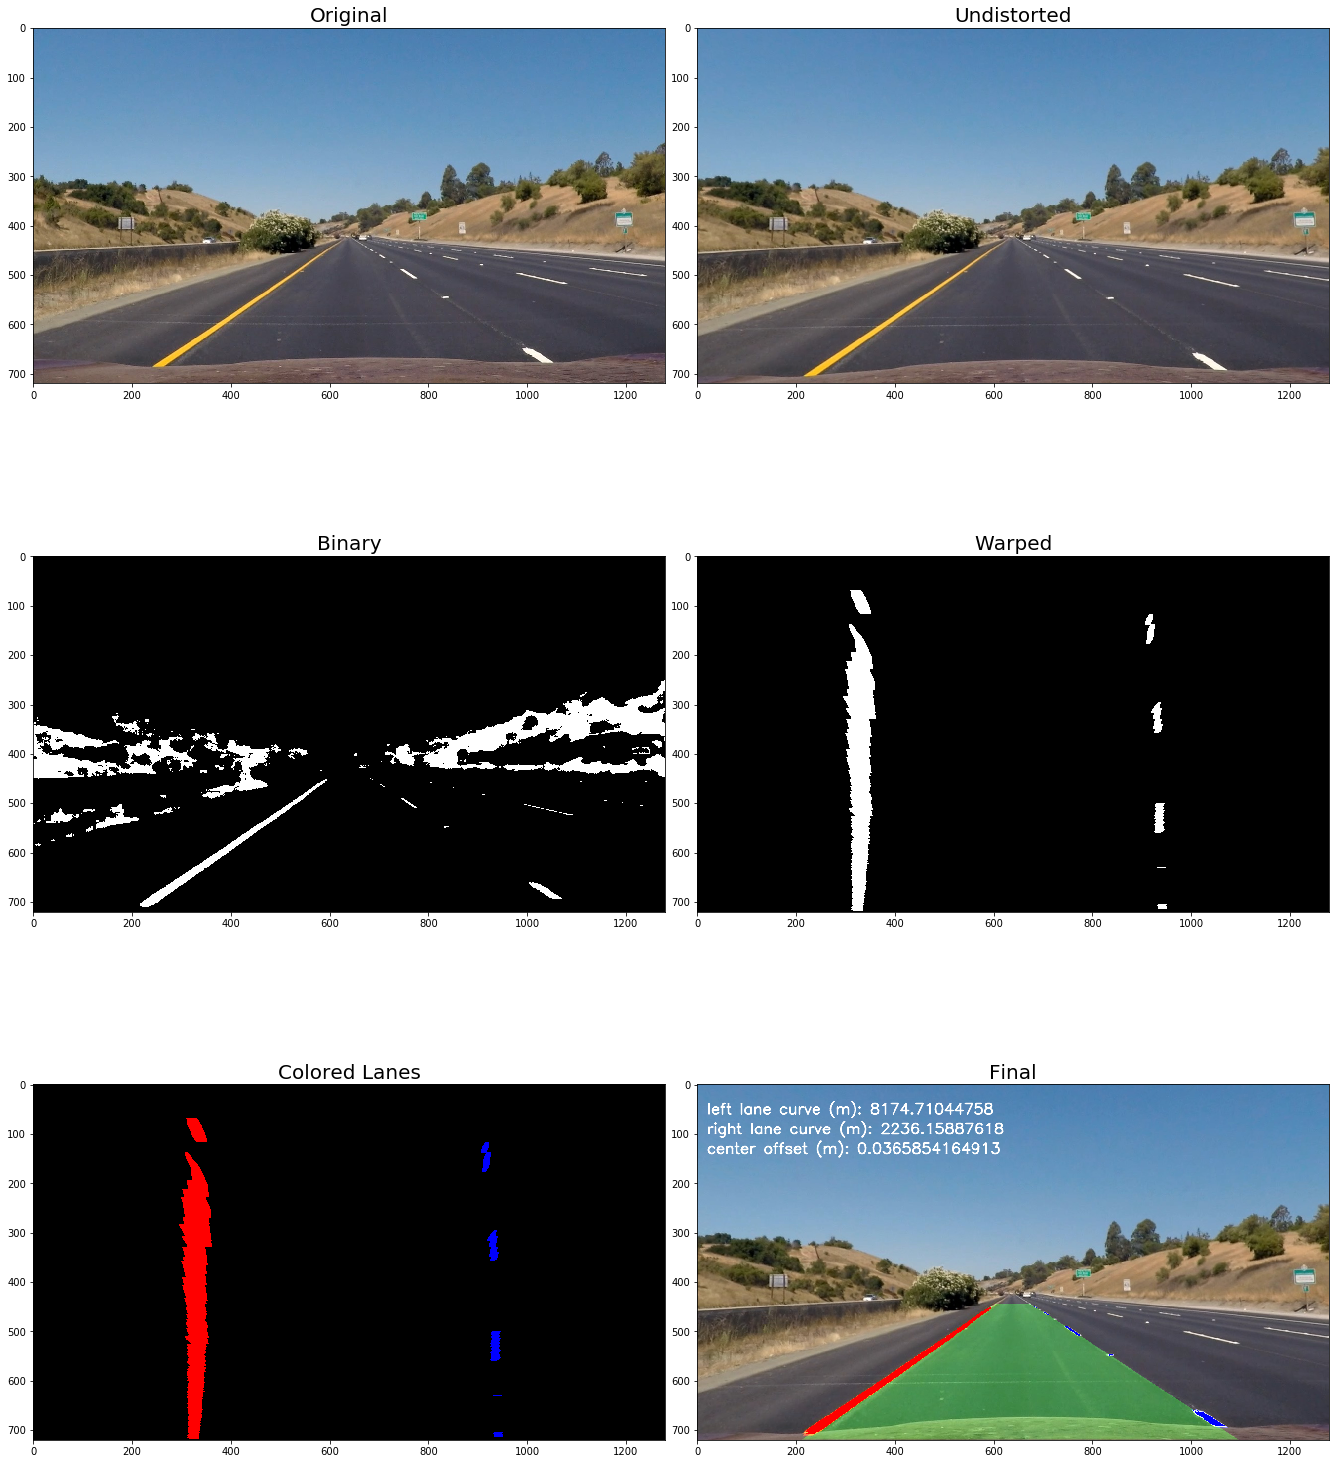

In [6]:
# Used for converting pixel to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Parameters for detection window
margin = 100
minpix=50
nwindows=10

# Coordinates and warp transformation matrices
src = np.float32(((602,445), (200,720), (1130,720), (682,445)))
dst = np.float32(((320,0), (320,720), (960,720), (960,0)))
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

font = cv2.FONT_HERSHEY_SIMPLEX

# Load mtx and dist from camera calibration pickle file
with open("camera_cal_pickle.p", mode='rb') as f:
    data = pickle.load(f)
    mtx = data['mtx']
    dist = data['dist']
    
# Function to undistort image based on camera calibration
def undistort_image (img):
    return cv2.undistort(img, mtx, dist, None, mtx)

# CIELAB color space transformation based on channel and threshold
def lab_thresh(img, chan=2, thresh=(0, 255)):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    lab_chan = lab[:,:,chan]
    binary_output = np.zeros_like(lab_chan)
    binary_output[(lab_chan > thresh[0]) & (lab_chan <= thresh[1])] = 1
    return binary_output

# Creates binary image for lane detection
def final_binary (undist):
    binary_output = np.zeros_like(undist[:,:,0])
    lab1 = lab_thresh(undist, chan=2, thresh=(150, 255))
    lab2 = lab_thresh(undist, chan=0, thresh=(215, 255))
    binary_output[(lab1==1) | (lab2==1)] = 1
    return binary_output

def warp_image (undist, M):
    img_size = (undist.shape[1], undist.shape[0])
    return cv2.warpPerspective(undist, M, img_size)

# Sliding window search to find lane lines
# Assuming you have created a warped binary image called "binary_warped"
def window_search(binary_warped, margin=100, minpix=50):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 8
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    return out_img, left_fit, right_fit

# Used with existing best fit lines and new binary_warped image
def fit_based_search (binary_warped, left_fit, right_fit, margin=100):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    return left_fit, right_fit

# Returns curvature of left and right lanes in meters
def real_lane_curvature(left_fit, right_fit, ploty):
    # Define conversions in x and y from pixels space to meters
    # Fit new polynomials to x,y in world space
    y_eval = np.max(ploty)
    leftx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    rightx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    return left_curverad, right_curverad

# Returns the car's offset from lane center based on best fit lines
# Positive offset means car's position is right of center
def car_offset (undist, left_fit, right_fit):
    y_max = undist.shape[0]
    leftx_y_max = left_fit[0]*y_max**2 + left_fit[1]*y_max + left_fit[2]
    rightx_y_max = right_fit[0]*y_max**2 + right_fit[1]*y_max + right_fit[2]
    lane_center = (leftx_y_max + rightx_y_max) / 2
    offset = undist.shape[1]/2 - lane_center
    return offset * xm_per_pix

# Draw lane on undistorted image
def draw_lane(undist, binary_warped, left_fit, right_fit, Minv):
    ploty = np.linspace(0, binary_warped[0].shape[0]-1, binary_warped[0].shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw the lines on
    color_warp = np.zeros_like(binary_warped).astype(np.uint8)
    #color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    fill_image = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0]))
    lane_image = cv2.warpPerspective(binary_warped, Minv, (undist.shape[1], undist.shape[0]))
    
    # Combine the result with the original image
    drawn_fill = cv2.addWeighted(undist, 1, fill_image, 0.3, 0)
    drawn_fill[lane_image[:,:,0] == 255, 1] = 0
    drawn_fill[lane_image[:,:,0] == 255, 2] = 0
    drawn_fill[lane_image[:,:,2] == 255, 0] = 0
    drawn_fill[lane_image[:,:,2] == 255, 1] = 0
    drawn_lanes = cv2.addWeighted(drawn_fill, 1, lane_image, 1, 0)
    
    # Print lane curvatures and offset on image
    left_curve, right_curve = real_lane_curvature(left_fit, right_fit, ploty)
    offset = car_offset(undist, left_fit, right_fit)
    left_curve_text = 'left lane curve (m): ' + str(left_curve)
    right_curve_text = 'right lane curve (m): ' + str(right_curve)
    offset_text = 'center offset (m): ' + str(offset)
    cv2.putText(drawn_lanes, left_curve_text,(20,60), font, 1, (255,255,255), 2, cv2.LINE_AA)
    cv2.putText(drawn_lanes, right_curve_text,(20,100), font, 1, (255,255,255), 2, cv2.LINE_AA)
    result = cv2.putText(drawn_lanes, offset_text,(20,140), font, 1, (255,255,255), 2, cv2.LINE_AA)
    
    return drawn_lanes

test_image = mpimg.imread('test_images/straight_lines1.jpg')
undist = undistort_image(test_image)
binary = final_binary(undist)
binary_warped = warp_image(binary, M)
lanes_warped, left_fit, right_fit = window_search(binary_warped)
final_image = draw_lane(undist, lanes_warped, left_fit, right_fit, Minv)

# Plot the result for x gradient
f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(24, 24))
f.tight_layout()

ax1.imshow(test_image)
ax1.set_title('Original', fontsize=20)
ax2.imshow(undist)
ax2.set_title('Undistorted', fontsize=20)

ax3.imshow(binary, cmap='gray')
ax3.set_title('Binary', fontsize=20)
ax4.imshow(binary_warped, cmap='gray')
ax4.set_title('Warped', fontsize=20)

ax5.imshow(lanes_warped)
ax5.set_title('Colored Lanes', fontsize=20)
ax6.imshow(final_image)
ax6.set_title('Final', fontsize=20)
plt.subplots_adjust(left=0., right=0.75, top=0.9, bottom=0.0)

## 4. Process Video
Vehicle and lane detection methods are called. For HOG subsampling multiple scale values are used. A circular buffer (deque) is used to create cumilating heat maps.

In [17]:
def process_frame(original_image, heat_thresh=32, heat_queue = deque(maxlen=25)):
    
    # Scale image from 0 to 1
    image = original_image.astype(np.float32)/255.0
    
    # Lane detection
    original_image = undistort_image(original_image)
    binary = final_binary(original_image)
    binary_warped = warp_image(binary, M)
    lanes_warped, left_fit, right_fit = window_search(binary_warped)
    lanes_image = draw_lane(original_image, lanes_warped, left_fit, right_fit, Minv)

    # Perform HOG subsampling as multiple scales
    all_ystart = (360, 360, 360, 360)
    all_ystop = (660, 660, 660, 660)
    all_scales = (0.9, 1.1, 1.4, 1.7)
    all_hot_windows = []
    for ystart, ystop, scale in zip(all_ystart, all_ystop, all_scales):
        all_hot_windows += find_cars(image, ystart, ystop, scale, svc, 
                                     X_scaler, orient, pix_per_cell, 
                                     cell_per_block, spatial_size, 
                                     hist_bins, color_space)
    '''
    
    all_ystart = 360
    all_ystop = 660
    all_scales = 1.5
    
    all_hot_windows = find_cars(image, all_ystart, all_ystop, all_scales, svc, 
                                     X_scaler, orient, pix_per_cell, 
                                     cell_per_block, spatial_size, 
                                     hist_bins, color_space)

    '''
    
    heat = np.zeros_like(original_image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat, all_hot_windows)
    #print('heat max 1:', np.max(heat))
    
    # Add heat to circular buffer and find total
    heat_queue.append(heat)
    total_heat = np.sum(heat_queue, axis=0).astype(np.uint8)
    # Apply threshold to help remove false positives
    total_heat = apply_threshold(total_heat, heat_thresh)   
    heatmap = np.clip(total_heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    
    return draw_labeled_bboxes(np.copy(lanes_image), labels)

In [18]:
input_video = 'project_video.mp4'
output_video = 'output_video_v2.mp4'
clip = VideoFileClip(input_video)
#clip = VideoFileClip(input_video).subclip(40,50)
processed = clip.fl_image(process_frame) #NOTE: this function expects color images!!
%time processed.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video output_video_v2.mp4
[MoviePy] Writing video output_video_v2.mp4



 12%|█▏        | 147/1261 [08:37<55:42,  3.00s/it]


 24%|██▎       | 298/1261 [16:14<51:53,  3.23s/it]


 36%|███▌      | 449/1261 [24:36<43:56,  3.25s/it]


 48%|████▊     | 600/1261 [35:56<50:16,  4.56s/it]


 60%|█████▉    | 751/1261 [44:31<27:49,  3.27s/it]


 72%|███████▏  | 902/1261 [52:27<19:59,  3.34s/it]


 83%|████████▎ | 1052/1261 [1:00:14<10:28,  3.01s/it]


 95%|█████████▍| 1195/1261 [1:07:46<03:18,  3.01s/it]


100%|█████████▉| 1260/1261 [1:11:09<00:03,  3.12s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video_v2.mp4 

CPU times: user 1h 9min 54s, sys: 4min 4s, total: 1h 13min 58s
Wall time: 1h 11min 10s
